In [1]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import shgo
from scipy.optimize import NonlinearConstraint as NLC
from scipy.optimize import LinearConstraint as LC

import numpy as np
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import cvxpy as cp

from RKHS import Gram

In [2]:
# The differentiable kernel function with parameters c,l not filled.
def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return c * np.exp(-(np.linalg.norm(x1-x2+small_sig,axis = -1)**2) / l)

def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,np.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*np.log(np.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*np.log(np.linalg.det(KA))

In [8]:
def rand_search(x0,R,objective):
    best_xs = []
    best_val = -np.inf
    
    for _ in range(50000):

        xs = [x0]
        for i in range(T-1):

            cand_x = 0
            while True:
                r = step_size*np.random.rand()

                theta = np.random.rand()*2*np.pi

                cand_x = xs[-1]+r*np.array([np.cos(theta),np.sin(theta)])

                if np.linalg.norm(cand_x-x0)<=R:
                    break

            xs.append(cand_x)

        xs = np.array(xs)
        val = objective(xs)

        if val>best_val:
            best_xs = xs
            best_val=val
            
    return best_xs,best_val

In [9]:
def h(r,c,l):
    return c * np.exp(-(r**2) / l**2)

In [10]:

T = 7

c = 1
l = 1
var_0 = 0.01
objective = lambda z: GPMI(z,c=c,l=l,var_0=var_0)


search_region_center = np.array([0,0])
step_size = 1

In [11]:
kernel = partial(k,c=c,l=l)

# Random search I

**No** bounded search region constraint.

Fix $||x_t-x_{t-1}||=D$, and search using random direction.

$$
    x_t\gets x_{t-1} + D * \text{ random unit vector}
$$


In [12]:
rand,_ = rand_search(search_region_center,\
                         np.inf,objective)

In [13]:
sols = {'Random Search': rand,
        'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size
       }


# Solve for the upper bound


$$
    \max_S \log(\det(I+\sigma^{-2}S))\\
    S_{ii}=c\\
    S_{i,i+1}=S_{i+1,i}\geq d\\
    S\succeq 0\\
    (\text{Without admissibility constraints})
$$

In [14]:
n = T
c = 1
var = var_0


d = h(step_size,c=c,l=l)

I = np.eye(n)

S = cp.Variable((n,n),symmetric=True)

constraints = [cp.diag(S)==c]

constraints+=[S[i,i+1]>=d for i in range(0,n-1)]

constraints+=[S>>0]

prob = cp.Problem(cp.Maximize(1/2*cp.log_det(I+ S/var)),constraints)

upper_bound = prob.solve()

# Compare the random search value and the upper bound

In [15]:
upper_bound

15.725918264309918

In [16]:
objective(sols['Random Search']) # Mutual information achieved by the random search

1.5213746144788125e+01

In [17]:
upper_bound-(objective(sols['Random Search'])) 

5.12172119521793e-01

In [18]:
(upper_bound-(objective(sols['Random Search'])))/np.abs(upper_bound) # The 'competitive ratio'

3.2568662186434685e-02

In [19]:
S.value

array([[0.9999994 , 0.36787981, 0.13401489, 0.0488275 , 0.01776215,
        0.00641178, 0.00228413],
       [0.36787981, 1.00000013, 0.36787983, 0.13400823, 0.04881001,
        0.01775389, 0.00643907],
       [0.13401489, 0.36787983, 0.99999992, 0.36787979, 0.13401547,
        0.04884005, 0.01780577],
       [0.0488275 , 0.13400823, 0.36787979, 0.99999997, 0.36787977,
        0.13403017, 0.04885486],
       [0.01776215, 0.04881001, 0.13401547, 0.36787977, 0.99999931,
        0.3678795 , 0.13401632],
       [0.00641178, 0.01775389, 0.04884005, 0.13403017, 0.3678795 ,
        1.0000003 , 0.3678793 ],
       [0.00228413, 0.00643907, 0.01780577, 0.04885486, 0.13401632,
        0.3678793 , 1.0000003 ]])

In [20]:
Gram(kernel,sols['Random Search'])

array([[1.00000000e+00, 5.41557297e-01, 4.49454562e-01, 8.70891888e-02,
        3.45760094e-03, 4.91158978e-05, 6.43436923e-08],
       [5.41557297e-01, 1.00000000e+00, 4.82778271e-01, 5.78949840e-02,
        4.13425112e-03, 4.21419595e-05, 6.47757881e-08],
       [4.49454561e-01, 4.82778271e-01, 1.00000000e+00, 4.98001315e-01,
        9.11452973e-02, 3.80571244e-03, 2.26837262e-05],
       [8.70891887e-02, 5.78949840e-02, 4.98001315e-01, 1.00000000e+00,
        4.80704942e-01, 8.04108689e-02, 1.86211443e-03],
       [3.45760094e-03, 4.13425111e-03, 9.11452972e-02, 4.80704942e-01,
        1.00000000e+00, 4.96231063e-01, 5.06260848e-02],
       [4.91158977e-05, 4.21419594e-05, 3.80571244e-03, 8.04108688e-02,
        4.96231063e-01, 1.00000000e+00, 4.29290224e-01],
       [6.43436922e-08, 6.47757880e-08, 2.26837261e-05, 1.86211443e-03,
        5.06260848e-02, 4.29290223e-01, 1.00000000e+00]])

In [117]:
S.value-Gram(kernel,sols['Random Search'])

array([[-6.01916709e-07,  3.67277513e-07,  4.66158701e-02,
         4.45789321e-02,  1.76539640e-02,  6.41076525e-03,
         2.28412708e-03],
       [ 3.67484168e-07,  1.29211274e-07,  3.86938520e-07,
         6.55941163e-03,  4.33314301e-02,  1.74064020e-02,
         6.43845421e-03],
       [ 4.66158702e-02,  3.87007626e-07, -8.19363816e-08,
         3.49895094e-07,  1.73969063e-02,  4.25333471e-02,
         1.77403724e-02],
       [ 4.45789321e-02,  6.55941172e-03,  3.50093375e-07,
        -2.57991901e-08,  3.29528353e-07, -1.12130721e-02,
         4.48562830e-02],
       [ 1.76539640e-02,  4.33314301e-02,  1.73969064e-02,
         3.29606116e-07, -6.92985199e-07,  6.08856539e-08,
         7.19259354e-02],
       [ 6.41076525e-03,  1.74064020e-02,  4.25333471e-02,
        -1.12130720e-02,  6.10758153e-08,  3.02156622e-07,
        -1.44144992e-07],
       [ 2.28412708e-03,  6.43845421e-03,  1.77403724e-02,
         4.48562830e-02,  7.19259355e-02, -1.43993054e-07,
         2.9727723

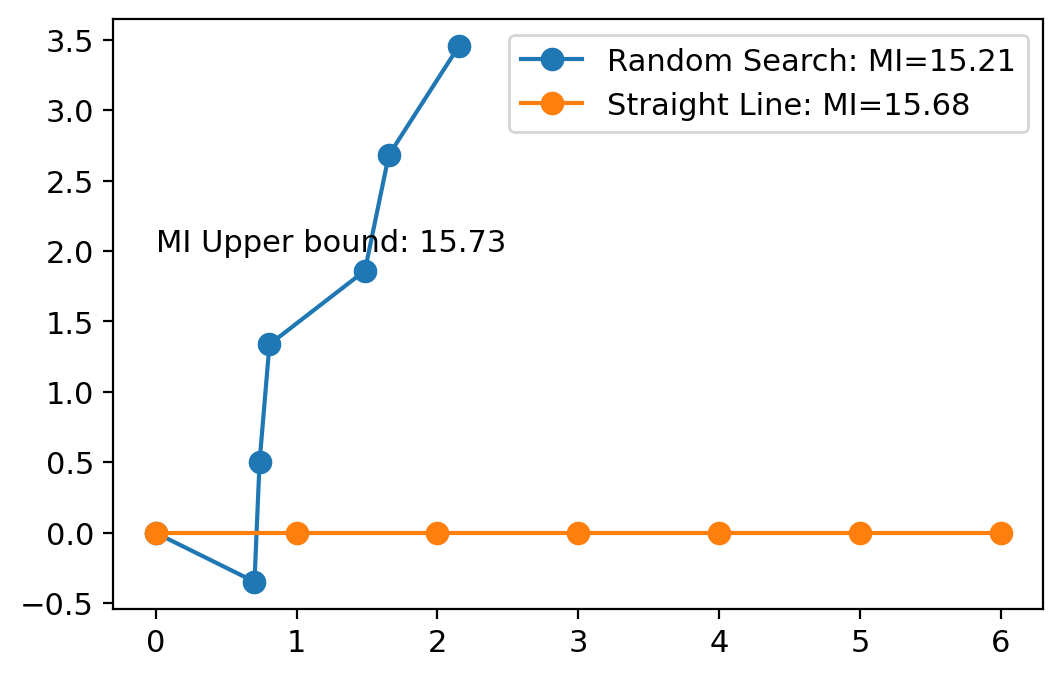

In [21]:

plt.rc('font',size=11)
plt.figure(dpi=200)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}: MI={:.2f}".format(key,objective(val)))
    
    plt.gca().set_aspect('equal')

plt.text(0.,2.,'MI Upper bound: {:.2f}'.format(upper_bound))
# circ = plt.Circle(search_region_center,search_region_radius,label='Search Region Boundary',fill=False)
# plt.gca().add_patch(circ)
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.legend()
plt.show()

# Random search II

Adding bounded search region constraint.

Fix $||x_t-x_{t-1}||=D$, and search using random direction.

$$
    \hat{x}_t\gets x_{t-1} + D * \text{ random unit vector}
$$

If $\hat{x}_t$ is outside the search region, pick a new random unit vector and try again, until a feasible $\hat{x}_t$ is found. Then set $x_t\gets \hat{x}_t$.


In [22]:
search_region_radius = 1

In [23]:
rand,_ = rand_search(search_region_center,\
                         search_region_radius,objective)

In [24]:
sols = {'Random Search': rand,
        'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size
       }


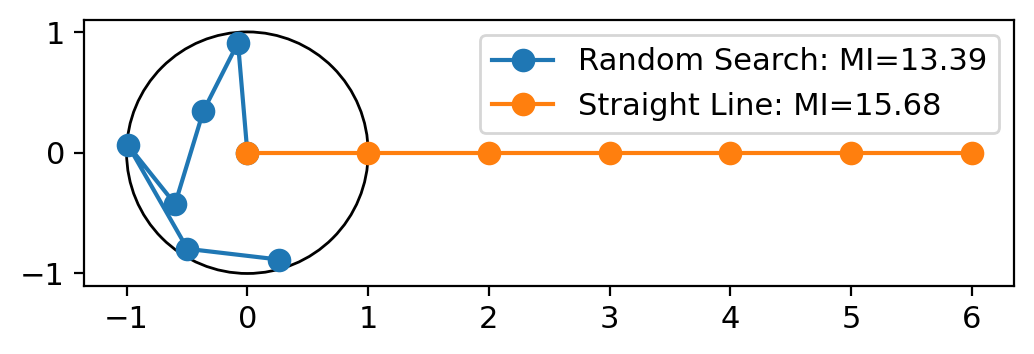

In [25]:

plt.rc('font',size=11)
plt.figure(dpi=200)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}: MI={:.2f}".format(key,objective(val)))
    
    plt.gca().set_aspect('equal')

circ = plt.Circle(search_region_center,search_region_radius,fill=False)
plt.gca().add_patch(circ)
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.legend()
plt.show()

# Solve for the upper bound


$$
    \max_S \log(\det(I+\sigma^{-2}S))\\
    S_{ii}=c\\
    S_{i,i+1}=S_{i+1,i}\geq d\\
    S_{i,j}\geq E\\
    S\succeq 0\\
    (\text{Without admissibility constraints})
$$

In [26]:
n = T
c = 1
var = var_0


d = h(step_size,c=c,l=l)

E = h(2*search_region_radius,c=c,l=l)

I = np.eye(n)

S = cp.Variable((n,n),symmetric=True)

constraints = [cp.diag(S)==c]

constraints+=[S[i,i+1]>=d for i in range(0,n-1)]

constraints+= [S>=E]

constraints+=[S>>0]

prob = cp.Problem(cp.Maximize(1/2*cp.log_det(I+ S/var)),constraints)

upper_bound = prob.solve()

In [27]:
prob.value

15.725753663755913

In [28]:
S.value

array([[1.00000084, 0.36787943, 0.13442268, 0.05035091, 0.02212195,
        0.01831588, 0.01831607],
       [0.36787943, 0.99999983, 0.36788053, 0.13470499, 0.05117253,
        0.02431043, 0.01831516],
       [0.13442268, 0.36788053, 1.00000056, 0.36787952, 0.13472006,
        0.05116979, 0.02211748],
       [0.05035091, 0.13470499, 0.36787952, 0.99999953, 0.36788072,
        0.13469734, 0.05033683],
       [0.02212195, 0.05117253, 0.13472006, 0.36788072, 1.00000047,
        0.36788027, 0.13441281],
       [0.01831588, 0.02431043, 0.05116979, 0.13469734, 0.36788027,
        1.0000011 , 0.36788058],
       [0.01831607, 0.01831516, 0.02211748, 0.05033683, 0.13441281,
        0.36788058, 1.00000173]])

In [29]:
Gram(kernel,sols['Random Search'])

array([[1.        , 0.43388644, 0.77722815, 0.58344368, 0.37648315,
        0.41487202, 0.42603002],
       [0.43388644, 1.        , 0.66936356, 0.12815971, 0.21239199,
        0.0456329 , 0.03540512],
       [0.77722815, 0.66936356, 1.        , 0.52296223, 0.62584124,
        0.26707986, 0.14817401],
       [0.58344368, 0.12815971, 0.52296223, 1.        , 0.68000364,
        0.8622508 , 0.38420993],
       [0.37648315, 0.21239199, 0.62584124, 0.68000364, 1.        ,
        0.37786133, 0.08559164],
       [0.41487202, 0.0456329 , 0.26707986, 0.8622508 , 0.37786133,
        1.        , 0.55628081],
       [0.42603002, 0.03540512, 0.14817401, 0.38420993, 0.08559164,
        0.55628081, 1.        ]])